In [155]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


Date last modified: 2018 - 04 - 04


In [156]:
%matplotlib notebook
import pandas as pd
import numpy as np
import sys
from numpy.linalg import inv
import math
from dateutil.parser import parse
import matplotlib.pyplot as plt
from dateutil.parser import parse

from scipy import stats

In [157]:
train_df = pd.read_csv("../input/train_1.csv")

page_details = pd.DataFrame([i.split("_")[-3:] for i in train_df["Page"]])
page_details.columns = ["project", "access", "agent"]

train_df = page_details.merge(train_df, how="inner", left_index=True, right_index=True)
enWiki_df = train_df.groupby('project').get_group('en.wikipedia.org').groupby('agent').get_group('all-agents')

In [158]:
def findIndex(name):
    count,__ = train_df.shape
    for i in range(count):
        if train_df.iloc[i,3] == name:
            return i

In [159]:
import pickle
def save_obj(obj, name ):
    with open('./../obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('./../obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
def hasNaN(u):
    row, col = u.shape
    for i in range(col):
        if np.isnan(u[0,i]):
            return True
    return False

        
bestWeeklySine = load_obj("sineall")


Input Processing
---------------------
The following few cells can be used for both cross validation purpose as well as final train & test -ing.

If you want to use cross-validation:

```Python
    crossValidation = True
    ```
    
else if you want to do final training and testing

```Python
    crossValidation = False
    ```

Page Name:  2002_FIFA_World_Cup_en.wikipedia.org_desktop_all-agents
Min: 596.0 Max: 7066.0
Power to be raised: 0.18159
Addtional sine signal in use
u.shape:  (2, 550)


<IPython.core.display.Javascript object>


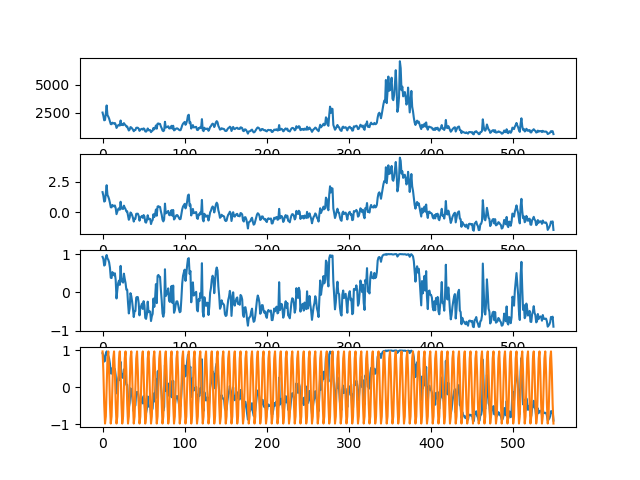

In [201]:
crossValidation = False
applyTanh = True
pageNo = 19
print 'Page Name: ', enWiki_df.iloc[pageNo,3]
num = findIndex(enWiki_df.iloc[pageNo,3])

signal = np.matrix(train_df.iloc[num,4:].values)
if hasNaN(signal):
     raise Exception('Some nan values found !')

        
_, length = signal.shape
ignorelen = 30                                      # Useful if you don't want to touch the testing data at all
if not crossValidation or ignorelen == 0:
    u = signal[:]
    siglen = length
else:
    u = signal[0,:-ignorelen]
    siglen = length - ignorelen

minimum, maximum = signal.min(), signal.max()

RESCALED_MAX = 5
ROUND = 5
powerRaise = round( math.log(RESCALED_MAX, max(train_df.iloc[num,4:].values)), ROUND)

print "Min:",minimum , "Max:", maximum
print "Power to be raised:", powerRaise

EXPECTED_MIN =2
shift =0 
mean = 0
sd = 1
if minimum <= EXPECTED_MIN:
    shift = EXPECTED_MIN

def inputmapping(x):
    global mean
    global sd
    scaled_shifted_sig, mean, sd = helper_inputmapping(x)
    return scaled_shifted_sig

def helper_inputmapping(x):   # maps the input to zero mean however does not save the mean to global variable        
    scaled_sig = np.power(x.astype(float)+shift,powerRaise)
    mean = np.mean(scaled_sig)
    sd = np.std(scaled_sig.astype(float)  , ddof=1)
    if applyTanh:
        return np.tanh( (scaled_sig - mean)/sd ), mean,sd
    else:
        return   (scaled_sig - mean)/sd, mean,sd


def invinputmapping(y):
    if applyTanh:
        return  np.power(np.arctanh(y) * sd +mean, 1/powerRaise) - shift 
    else:
        return  np.power(y * sd +mean, 1/powerRaise) - shift

def sine(period, length):
    x = np.array(length)
    y = np.sin(2 * np.pi * x / period)
    return y


u = inputmapping(u.astype(float))

startIndex = bestWeeklySine[num][0]                                 # gives the starting point for sine wave with highest correlation to input signal

useSine = True
sf_sin = 1
if useSine:
    print "Addtional sine signal in use"
    u = np.vstack((u,sf_sin * sine(7,range(startIndex, startIndex + siglen))))

print "u.shape: ",u.shape
figureNo = 0
figureNo += 1
plt.figure(figureNo)

plt.subplot(4,1,1)
plt.plot(signal.T)

plt.subplot(4,1,2)
plt.plot(np.arctanh(  u[0,:].T)  )

plt.subplot(4,1,3)
plt.plot(inputmapping(signal.T))

plt.subplot(4,1,4)
plt.plot(inputmapping(signal.T))
if useSine:
    plt.plot(u[1,:].T)

Findings:

    1) When used mean signal using sine signal is improves the prediction
    2) When used all the add. signals independently, signal degrades the prediction

Overall, case 1) has better prediction than case 2)

In [183]:
__, u_len =  u.shape 
if crossValidation:
    testlen = 0
else:
    testlen = ignorelen
pwin = 7
if not crossValidation and testlen < pwin:
    raise Exception("Prediction window cannot be greater than the testlen itself.")
trainlen = u_len - testlen

def make_teachers():
    teachers = np.zeros((pwin,trainlen-pwin))
    for i in range(pwin):
        teachers[i,:] =  u[0, i+1:trainlen -(pwin)+i+1].astype(float)     # Assumption: u is already preprocessed (i.e logged and shifted) 
     
    return np.matrix(teachers)


d = u[0,pwin:trainlen]   # for now lets just predict on single horizon
print d.shape

(1, 513)


In [184]:
try:
    corrCoeffDict = load_obj("corrCoeffDict"+str(num))
except:
    print "Variable file not found. Calculating the correlation."
    print "Be patient! It takes quite a time."
    count,__ = train_df.shape
    corrCoeffDict = {}
    for i in range(count):
        corrCoeff,__ =  stats.pearsonr(train_df.iloc[num,4:].values, train_df.iloc[i,4:].values)
        if not np.isnan(corrCoeff) and train_df.iloc[num,3] != train_df.iloc[i,3]:
            if len(corrCoeffDict.keys()) <20:
                corrCoeffDict[corrCoeff] = i
            elif abs(corrCoeff) > min(np.abs(corrCoeffDict.keys())):
                if min(np.abs(corrCoeffDict.keys())) in corrCoeffDict:
                    del corrCoeffDict[ min(np.abs(corrCoeffDict.keys())) ]
                else:
                    del corrCoeffDict[-1* min(np.abs(corrCoeffDict.keys())) ]
                corrCoeffDict[corrCoeff] = i
    save_obj( corrCoeffDict,'corrCoeffDict'+ str(num))

print "Done."
# help (np.reshape)

Done.


shift orginal signal and find signals that are correlated to explore the pattern
network motives:

In [185]:
# figureNo += 1
# plt.figure(figureNo)
# for _,j in corrCoeffDict.iteritems():
#     print train_df.iloc[j,3]
#     plt.plot(train_df.iloc[j,4:].values)
    

The best configuration for additional signal(cell below) found was
```Python
useAddSig = True
useMeanSig = False 
sf_addSig = 1.0
```

Initial shape of u:  (22, 550)
(2, 550)
Using sine signal
Each additional signals are used independently


<IPython.core.display.Javascript object>


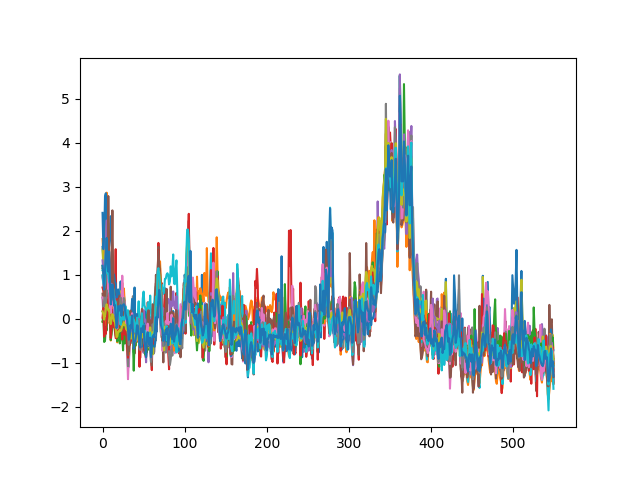

Final shape of u:  (22, 550)


In [187]:
useAddSig = True
useMeanSig = False # use the average svalue of additional signals or use them independently
sf_addSig = 1.0
if useAddSig:
    print "Initial shape of u: ",u.shape
    if useMeanSig:
        # Step 1: compute mean signal
        sumSig = np.zeros((siglen))
        for i in corrCoeffDict.values():
            test, _, _ = helper_inputmapping(train_df.iloc[i,4:4+siglen].values)
            sumSig  += test
        # Step 2: reset the dimension of u 
        if useSine:
            u = np.reshape(u[:2,:],(2,siglen))             # if u already has multiple helper signal delete them before adding newer ones
            print "Using sine signal"
            print u.shape
        else:
            u = np.reshape(u[0,:],(1,siglen))
        #Step 3: stack the mean of addtional signal
        
        u = np.vstack((u, sf_addSig* sumSig/len(corrCoeffDict)))                 # !!!!!!!!!!!!!
        print "Mean of additional signals is used"
        figureNo += 1
        plt.figure(figureNo)
        plt.plot(u[0,:].T)
        plt.plot(u[1,:].T)
        if useSine:
            plt.plot(u[2,:].T)
    else:
        # Step 1: reset the dimension of u 
        if useSine:
            u = np.reshape(u[:2,:],(2,siglen))             # if u already has multiple helper signal delete them before adding newer ones
            print u.shape
            print "Using sine signal"
        else:
            u = np.reshape(u[0,:],(1,siglen))
        #Step 2: stack the addtional signals
        for _,j in corrCoeffDict.iteritems():
# #             print j
#             print train_df.iloc[j,3]
            u = np.vstack((u, sf_addSig* 1/len(corrCoeffDict) * helper_inputmapping(train_df.iloc[j,4:4+siglen].values.astype(float))[0][:siglen]))     #!!!!!!!
        print "Each additional signals are used independently"
        
        figureNo +=1
        plt.figure(figureNo)
        count =0
        plt.plot(u[count,:].T)
        if useSine:
            count+=2
#             plt.plot(u[count,:].T)
        for _,_ in corrCoeffDict.iteritems():
            plt.plot(20.0 *u[count,:].T)
            count+=1
    print "Final shape of u: ", u.shape
    
else:
    if useSine:
        u = np.reshape(u[:2,:],(2,siglen))             # if u already has multiple helper signal delete them before adding newer ones
        print "Final shape of u: ", u.shape
        print "Using sine signal"
    else:
        u = np.reshape(u[0,:],(1,siglen))
        print "No additional signals used"

Forgot sine wave


add cross validation



In [188]:
N = 100                                # Size of reservior

K, u_len =  u.shape                    # K: no of input signal
L,__     =  d.shape                    # L: no of output signal
np.random.seed(123)
W0    = np.random.rand(N,N) - 0.5       # The weights of synaptic links connecting the neurons
W_in0 = np.random.rand(N,K) - 0.5       # Weights for input links
                                        # The elements of W are in range of [-0.5, 0.5]
b0    = np.random.rand(N,1) - 0.5       # bias vector
W_fb0 = np.random.rand(N,L) - 0.5       # feedback weights matrix

eig_val, eig_vec = np.linalg.eig(W0)
W0 =  ( W0 / max(np.abs(eig_val)) )     # W with spectral radius of 1 unit

In [189]:
# Scaling factors
sf_W =   1.0                            # Scaling factor for W
sf_Win = 0.5                            # Scaling factor for W_in
sf_Wfb = 0.0000                         # zero for now
sf_b = 0.5                              # Scaling factor for bias
reg_coff = 1                            # Regularization cofficient
alpha = 1                               # leaky intregator neuron coffecient

W_fb = sf_Wfb* W_fb0 
W = sf_W * W0
W_in = sf_Win * W_in0
b = sf_b * b0

#===========================================================================================#
x = np.zeros((N,1))                       # State Vector of ESN
x_t = np.zeros((N,1))

S = np.zeros((trainlen-pwin,N+K));             # Contains Extended Systems States filled row-wise
S = np.matrix(S)
print S.shape
for t in range(trainlen - pwin):
    x_t = np.tanh( np.dot(W,x) + np.dot(W_in,u[:,t]) + b)
    x = (1-alpha) * x + alpha * x_t
    S[t,:] = np.vstack((x,u[:,t])).T
    
washout = 10
S_s = S[washout:,:]
d_s = d[:,washout:]
u_s = u[:,washout:]


(513, 122)


In [190]:
if crossValidation:
    startInd =  length - ignorelen - pwin - washout - 4 * 100
    endInd =  length - ignorelen
    NO_OF_FOLD = 4
    FOLD_LEN   = 100                                        # length of each fold
    indices = [ startInd+ z*FOLD_LEN for z in range(5) ]    # = [78, 178, 278, 378, 478]

    sumError = 0
    figureNo += 1
    plt.figure(figureNo)
    
    def nan2zero(x):
        row, col = x.shape
        for i in range(row):
            for j in range(col):
                if np.isnan(x[i,j]):
                    x[i,j] = 0
        return x
    for i in range(NO_OF_FOLD): 
        # Step 1: Divide [S_s] into training and validation sets
        initialPart = S_s[0:startInd, :]
        middlePart = S_s[startInd:indices[i], :]
        endPart = S_s[indices[i+1]:endInd, :]
        temp = np.vstack( (initialPart, middlePart) ) if middlePart.size else initialPart
        S_si = np.vstack( (temp, endPart) ) if endPart.size else temp  

        # Step 2: Divide [d_s] into training and validation sets
        initialPart = d_s[:, 0:startInd]
        middlePart = d_s[:, startInd:indices[i]]
        endPart = d_s[:, indices[i+1]:endInd]
        temp = np.hstack( (initialPart, middlePart) ) if middlePart.size else initialPart
        d_si = np.hstack( (temp, endPart) ) if endPart.size else temp

        # Step 3: Divide [] into training and validation sets

        d_t = d_s[:,indices[i]:indices[i+1]]
        u_t = u_s[:, indices[i]:indices[i+1]]

        #-------------------------------------------------------------------------------------------#
        W_out =  np.dot(np.dot(d_si, S_si), inv( np.dot(S_si.T, S_si) + reg_coff * np.eye(N+K) ) )   #correct
        Y = np.matrix(np.zeros((L,FOLD_LEN)))
        y = np.matrix(np.zeros((L,1)))

        for t in range(FOLD_LEN):
            x_t = np.tanh( np.dot(W,x) + np.dot(W_in,u_t[:,t]) + b )
            x = (1-alpha) * x + alpha * x_t
            y = np.dot(W_out, np.vstack((x,u_t[:,t])) )
            Y[:,t] = y
        error= NRMSE( nan2zero( invinputmapping(d_t) ) , nan2zero( invinputmapping(Y) ) ) 
#         if i != 1:
        sumError += error
        print error
        
        plt.subplot(4,1,i+1)
        plt.plot( nan2zero( invinputmapping(d_t.T) ) )
        plt.plot( nan2zero( invinputmapping(Y.T) ) )
        if i==0:
            plt.title("prediction vs desired values in each fold of CV")
    
    figureNo += 1
    plotNeuronsStates(S_s,[50,30,35])
    print "Average Error: ", sumError/NO_OF_FOLD

In [191]:
# W_out

bigger output weights very high is bad
should be less than 1
average of abs value of W_out should be around 0.1
use reg_coeff to tune

In [192]:
# Y.shape

nrmse error:  1.23867193717
Nrmse error:  1.21225493433


<IPython.core.display.Javascript object>


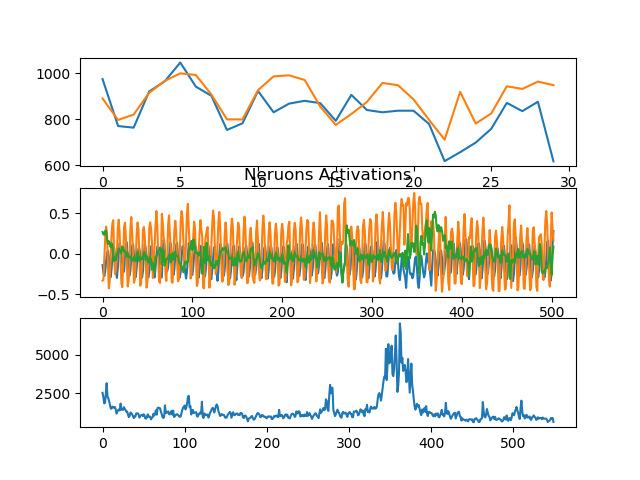

In [193]:
if not crossValidation:
    W_out =  np.dot(np.dot(d_s, S_s), inv( np.dot(S_s.T, S_s) + reg_coff * np.eye(N+K) ) )   #correct
    #===========================================================================================#

    Y = np.matrix(np.zeros((L,testlen)))
    y = np.matrix(np.zeros((L,1)))
    for t in range(trainlen-pwin,siglen-pwin):
        x_t = np.tanh( np.dot(W,x) + np.dot(W_in,u[:,t]) + b  + np.dot(W_fb, y))
        x = (1-alpha) * x + alpha * x_t
        y = np.dot(W_out, np.vstack((x,u[:,t])) )
        Y[:,t-trainlen] = y
    print "nrmse error: ", NRMSE(d[:,-testlen:],Y)
    print "Nrmse error: ", NRMSE(invinputmapping(d[:,-testlen:]), invinputmapping(Y) )
    figureNo += 1
    plt.figure(figureNo)
    plt.subplot(3,1,1)
    plt.plot(invinputmapping(u[0,-testlen:].T) )
    plt.plot( invinputmapping(Y.T) )
    plt.subplot(3,1,2)
    
    plotNeuronsStates(S_s,[50,30,35])
    plt.subplot(3,1,3)
    plt.plot(signal.T)

In [96]:
# stats.pearsonr(invinputmapping(d[:,-testlen:]), invinputmapping(Y) )
invinputmapping(d[:,-testlen:])

matrix([[ 824.,  781., 1043.,  738.,  693.,  869.,  858.,  732.,  864.,
         1185., 1153., 1055., 1276., 1415., 1601., 1374., 1214.,  959.,
          809., 1540., 2013., 1308.,  991., 1065.,  846.,  887., 1085.,
         1010.,  896.,  929.]])

In [ ]:
# print NRMSE(invinputmapping(d_t), invinputmapping(Y))
# plt.figure(35)
# plt.plot(invinputmapping(d_t).T)
# plt.plot(invinputmapping(Y).T)


In [170]:
def plotNeuronsStates(S, neurons):
    
    plt.figure(figureNo)
    for neuron in neurons:
        plt.plot(S[:,neuron])
    plt.title("Neruons Activations")
        
# plt.plot(np.array(u)[0,:-pwin])
# plotNeuronsStates(S_s,[62, 93, 13,50])

In [ ]:
# plotNeuronsStates(S_si,[62])

In [ ]:
# num = 20
# plt.plot( np.array(invinputmapping(Y))[num].tolist())
# plt.plot( np.array(invinputmapping(u[0,trainlen-pwin+1 +num:trainlen+num+1]))[0].tolist())
# print NRMSE(np.array(invinputmapping(u[0,trainlen-pwin+1 +num:trainlen+num+1]))[0],np.array(invinputmapping(Y))[0])

In [ ]:
# errSum = 0;
# for i in range(pwin):
#     temp = NRMSE(np.array(invinputmapping(Y))[i],  np.array(invinputmapping(u[0,trainlen-pwin+1 +i:trainlen+i+1]))[0])
# #     print stats.pearsonr(np.array(invinputmapping(Y))[i],  np.array(invinputmapping(u[0,trainlen-pwin+1 +i:trainlen+i+1]))[0])
#     print temp
#     errSum+= temp
# print "Average Error: ", errSum/pwin   

In [ ]:
# num =0
# # print "NRMSE Error: ", NRMSE(np.array(invinputmaping(Y))[num],  np.array(invinputmapping(u[0,trainlen-pwin+1 +num:trainlen+num+1]))[0])
# # print stats.pearsonr( np.array(invinputmapping(Y))[num].tolist(),np.array(invinputmapping(u[0,trainlen-pwin+1 +num:trainlen+num+1]))[0].tolist())
# plt.plot( np.array(invinputmapping(Y))[num].tolist())
# plt.plot( np.array(invinputmapping(u[0,trainlen-pwin+1 +num:trainlen+num+1]))[0].tolist())
# # 

In [17]:
def NRMSE(d,p):
    # takes d desired signal and p predicted signal
    if(d.shape != p.shape ):
        print("Dimension mismatch!!!\n")
        exit(0)
    error = np.absolute(d - p)
    SE = np.power(error,2)
    MSE = np.mean(SE)
    var = np.mean( d - np.mean(d) **2)
    NRMSE = math.sqrt(abs(MSE/var))            # doesn't work if (MSE/var) is not absoluted
    return NRMSE  

In [171]:
def NRMSE(d,p):
    # takes d desired signal and p predicted signal
    # for 1 dimensional d and p
    if(d.shape != p.shape ):
        print("Dimension mismatch!!!\n")
        exit(0)
    error = np.absolute(d - p)
    SE = np.power(error,2)
    MSE = np.mean(SE)
    var = np.mean( np.power( (d  - np.mean(d)), 2) )
#     print 'var = ' ,var
    nrmse = math.sqrt(abs(MSE/var))            # doesn't work if (MSE/var) is not absoluted
    return nrmse

